## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time
import sys
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, model_from_yaml
from keras.constraints import max_norm
from keras.layers import Input, Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
%matplotlib inline

# from IPython.display import Audio
# sound_file = './sound/beep.wav'

C:\Users\Vladislava\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the data

train = scipy.io.loadmat('TrainData.mat')
val = scipy.io.loadmat('ValData.mat')


In [3]:
Xtrain, Ytrain = train['X'], train['Y']
Xval, Yval = val['X'], val['Y']

### Arite, lez make a model

In [4]:
def CNNModel(inputShape, nConvLayers):
    
    input1 = Input(shape = inputShape)

    #convolutions
    x = input1
    
    
    for i in range(0,nConvLayers):
        
        nFilters = 128 if i>1 else 32*(i+1)
        inside = 3 if i>1 else 2
        for temp in range(0,inside):
            x = Conv1D(filters = nFilters,
                  kernel_size = 5,
                  padding = 'same',
                  strides = 1,
                  name = 'Conv1x5{}{}'.format(i,temp))(x)
            
            x = Activation('relu',name='ReLu{}{}'.format(i,temp))(x)
            x = BatchNormalization()(x)
            
        x = MaxPooling1D(2,
                      padding = 'same',
                      strides = 1,
                      name = 'MaxPooling1D{}'.format(i))(x)
    
    x = Dropout(0.5)(x)
    
    # Fully connected
    x = Flatten()(x)
    
    x = Dense(128, kernel_constraint = max_norm(3))(x)
    x = Activation('relu', name = 'reLU_dense')(x)
    x = Dropout(0.6)(x)
    
    x = Dense(4)(x)
    x = Activation('softmax',name = 'Softmax')(x)

    m = Model(input1,x)
    return m


In [5]:
def saveModelTopology(model,modelName):
    model_json = model.to_yaml()
    with open(modelName+'.yaml', "w") as yaml_file:
        yaml_file.write(model_json)
    print("Saved model to {}.yaml".format(modelName))
    return


In [6]:
def defCallbacks(weightFile):
    
    checkpoint = ModelCheckpoint(weightFile,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode='max')
    early = EarlyStopping(monitor='val_acc',
                          patience = 17,
                          verbose = 1,
                          mode='max')
#     def step_decay(epoch):
#         initial_lrate = 0.001
#         rate_drop = 0.25
#         nEpochs = 5
#         lrate = initial_lrate * math.pow(rate_drop, math.floor(epoch/nEpochs))
#         return lrate 
    
#     lrate = LearningRateScheduler(step_decay, verbose = 1)
    lr_plateau = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.2,
                                  patience = 8, min_lr = 0.00000001,
                                  verbose = 1)
    
    return [checkpoint, early, lr_plateau]
    

In [7]:
def fitModel(model, modelName, Xtrain, Ytrain, Xval, Yval, epochs,batch_size):
    
    tic = time.time()
    
    # make file name
    tm = time.gmtime()
    weightFile = 'BEST_WEIGHTS{}.{}.{}.{}.{}.{}.h5'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])
    
    #define callbacks
    callbacks = defCallbacks(weightFile)
    
    # FIT THE MODEL
    history = model.fit(x = Xtrain, y = Ytrain,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data = (Xval,Yval),
                        callbacks = callbacks)
    toc = time.time()
    print("Finished training in {} min ({} h)".format(round((toc-tic)/60,2),round((toc-tic)/3600,2)))

    
    # Save the weights
    #model.save_weights(str(modelName)+'.h5') # ???????
    
    return history

In [8]:
# def evaluateModel(model, modelName, Xval, Yval):
#     tic = time.time()
#     predictions = model.predict(Xval)
#     toc = time.time()
#     print('Finished prediction in: {} min'.format(round((toc-tic)/60,2)))

#     print('Evaluating...')
#     score = model.evaluate(Xval,Yval,verbose=1)
#     print(score)

#     #Save that stuff too pls.
#     tm = time.gmtime()    
#     predictionFile = 'Predictions-{}.{}.{}.{}.{}.{}.csv'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])

#     dfPredicted = pd.DataFrame(predictions)
#     dfPredicted = dfPredicted.idxmax(axis =1)
#     dfExpected = pd.DataFrame(Yval)
#     dfExpected = dfExpected.idxmax(axis =1)
#     df = pd.DataFrame({'Predicted':dfPredicted, 'Expected':dfExpected})
#     df.to_csv(predictionFile,index = False)
#     print('Saved predictions to: ', predictionFile)
    
#     bingos = sum(df['Predicted'] ==df['Expected'])
#     accRly = 100*bingos/df.shape[0]
#     print('Currently your actual accuracy on Xval is: {}%'.format(round(accRly,2)))
    
#     return accRly

In [9]:
histories = []
#modelDepths = []
accuracies = []
nConvLayers = 5   
epochs = 200
batch_size = 16

for i in range(2):
    
    model = CNNModel((Xtrain.shape[1],Xtrain.shape[2]),nConvLayers)
    opt = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer = opt,
             loss='categorical_crossentropy',
             metrics = ['accuracy'])
    #model.summary()
   
    modelName = 'CNN64batch'+ str(nConvLayers)
    #saveModelTopology(model,modelName)
    model.save(modelName+'CEO.h5')
    
    print('TRAINING...')

    history = fitModel(model,modelName, Xtrain, Ytrain, Xval, Yval, epochs,batch_size)
    histories.append(history.history)   
    #modelDepths.append(nConvLayers)
    
    

    
#     acc = evaluateModel(model, modelName, Xval, Yval)
#     accuracies.append(acc)
    
    
#     with open("hist.txt", "w") as f:
#         for h in histories:
#             f.write(str(h) +"\n")

#     with open("hist.txt", "r") as f:
#         for line in f:
#             histo.append(int(line.strip()))

TRAINING...
Train on 2719 samples, validate on 375 samples
Epoch 1/200
2719/2719 [==============================] - ETA: 13:22 - loss: 3.0460 - acc: 0.31 - ETA: 6:59 - loss: 4.0257 - acc: 0.2188 - ETA: 4:51 - loss: 3.8477 - acc: 0.250 - ETA: 3:47 - loss: 3.6556 - acc: 0.281 - ETA: 3:08 - loss: 3.5188 - acc: 0.275 - ETA: 2:42 - loss: 3.3900 - acc: 0.270 - ETA: 2:24 - loss: 3.2422 - acc: 0.276 - ETA: 2:10 - loss: 3.1894 - acc: 0.265 - ETA: 1:59 - loss: 3.0837 - acc: 0.277 - ETA: 1:50 - loss: 3.0350 - acc: 0.287 - ETA: 1:43 - loss: 3.1331 - acc: 0.289 - ETA: 1:37 - loss: 3.1703 - acc: 0.270 - ETA: 1:32 - loss: 3.2183 - acc: 0.264 - ETA: 1:27 - loss: 3.2255 - acc: 0.272 - ETA: 1:23 - loss: 3.1558 - acc: 0.266 - ETA: 1:20 - loss: 3.1918 - acc: 0.265 - ETA: 1:17 - loss: 3.2063 - acc: 0.264 - ETA: 1:14 - loss: 3.2379 - acc: 0.267 - ETA: 1:12 - loss: 3.1927 - acc: 0.269 - ETA: 1:09 - loss: 3.2533 - acc: 0.265 - ETA: 1:07 - loss: 3.2088 - acc: 0.267 - ETA: 1:05 - loss: 3.1436 - acc: 0.269 - ETA

2719/2719 [==============================] - ETA: 46s - loss: 1.1774 - acc: 0.43 - ETA: 43s - loss: 1.0901 - acc: 0.50 - ETA: 42s - loss: 1.2169 - acc: 0.45 - ETA: 41s - loss: 1.1756 - acc: 0.50 - ETA: 41s - loss: 1.2388 - acc: 0.46 - ETA: 40s - loss: 1.2057 - acc: 0.50 - ETA: 40s - loss: 1.1819 - acc: 0.51 - ETA: 40s - loss: 1.1837 - acc: 0.50 - ETA: 39s - loss: 1.2094 - acc: 0.49 - ETA: 39s - loss: 1.1952 - acc: 0.49 - ETA: 38s - loss: 1.1759 - acc: 0.47 - ETA: 38s - loss: 1.1742 - acc: 0.47 - ETA: 38s - loss: 1.1871 - acc: 0.47 - ETA: 38s - loss: 1.2127 - acc: 0.46 - ETA: 37s - loss: 1.2146 - acc: 0.45 - ETA: 37s - loss: 1.2073 - acc: 0.46 - ETA: 37s - loss: 1.2110 - acc: 0.44 - ETA: 37s - loss: 1.2121 - acc: 0.44 - ETA: 36s - loss: 1.1992 - acc: 0.45 - ETA: 36s - loss: 1.1965 - acc: 0.45 - ETA: 36s - loss: 1.1923 - acc: 0.44 - ETA: 35s - loss: 1.1957 - acc: 0.44 - ETA: 35s - loss: 1.1997 - acc: 0.43 - ETA: 35s - loss: 1.2072 - acc: 0.43 - ETA: 35s - loss: 1.2091 - acc: 0.42 - ETA: 

2719/2719 [==============================] - ETA: 47s - loss: 0.9797 - acc: 0.43 - ETA: 45s - loss: 1.0781 - acc: 0.40 - ETA: 43s - loss: 1.0252 - acc: 0.45 - ETA: 41s - loss: 1.1258 - acc: 0.46 - ETA: 41s - loss: 1.1211 - acc: 0.47 - ETA: 40s - loss: 1.1033 - acc: 0.50 - ETA: 40s - loss: 1.1312 - acc: 0.50 - ETA: 39s - loss: 1.1330 - acc: 0.49 - ETA: 39s - loss: 1.1202 - acc: 0.50 - ETA: 39s - loss: 1.1215 - acc: 0.48 - ETA: 38s - loss: 1.1044 - acc: 0.50 - ETA: 38s - loss: 1.0874 - acc: 0.50 - ETA: 38s - loss: 1.0712 - acc: 0.52 - ETA: 38s - loss: 1.0585 - acc: 0.53 - ETA: 37s - loss: 1.0786 - acc: 0.52 - ETA: 37s - loss: 1.0749 - acc: 0.53 - ETA: 37s - loss: 1.0673 - acc: 0.54 - ETA: 36s - loss: 1.0751 - acc: 0.53 - ETA: 36s - loss: 1.0792 - acc: 0.53 - ETA: 36s - loss: 1.0702 - acc: 0.53 - ETA: 36s - loss: 1.0743 - acc: 0.53 - ETA: 35s - loss: 1.0749 - acc: 0.53 - ETA: 35s - loss: 1.0677 - acc: 0.54 - ETA: 35s - loss: 1.0659 - acc: 0.55 - ETA: 35s - loss: 1.0605 - acc: 0.55 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 0.9918 - acc: 0.62 - ETA: 42s - loss: 0.8296 - acc: 0.62 - ETA: 41s - loss: 0.8576 - acc: 0.62 - ETA: 41s - loss: 0.8750 - acc: 0.60 - ETA: 40s - loss: 0.8110 - acc: 0.66 - ETA: 40s - loss: 0.7877 - acc: 0.68 - ETA: 39s - loss: 0.7860 - acc: 0.67 - ETA: 39s - loss: 0.7711 - acc: 0.68 - ETA: 39s - loss: 0.7422 - acc: 0.70 - ETA: 38s - loss: 0.7876 - acc: 0.66 - ETA: 38s - loss: 0.7972 - acc: 0.64 - ETA: 38s - loss: 0.7949 - acc: 0.64 - ETA: 38s - loss: 0.7844 - acc: 0.64 - ETA: 37s - loss: 0.7908 - acc: 0.65 - ETA: 37s - loss: 0.8035 - acc: 0.63 - ETA: 37s - loss: 0.7946 - acc: 0.63 - ETA: 37s - loss: 0.8160 - acc: 0.62 - ETA: 36s - loss: 0.8103 - acc: 0.63 - ETA: 36s - loss: 0.8100 - acc: 0.62 - ETA: 36s - loss: 0.8078 - acc: 0.62 - ETA: 36s - loss: 0.8051 - acc: 0.62 - ETA: 35s - loss: 0.8074 - acc: 0.63 - ETA: 35s - loss: 0.8118 - acc: 0.63 - ETA: 35s - loss: 0.8192 - acc: 0.63 - ETA: 35s - loss: 0.8227 - acc: 0.63 - ETA: 

2719/2719 [==============================] - ETA: 46s - loss: 0.5309 - acc: 0.68 - ETA: 44s - loss: 0.4751 - acc: 0.71 - ETA: 42s - loss: 0.5062 - acc: 0.75 - ETA: 41s - loss: 0.6196 - acc: 0.75 - ETA: 41s - loss: 0.6644 - acc: 0.71 - ETA: 40s - loss: 0.6620 - acc: 0.69 - ETA: 40s - loss: 0.6834 - acc: 0.69 - ETA: 39s - loss: 0.7141 - acc: 0.68 - ETA: 39s - loss: 0.7662 - acc: 0.68 - ETA: 39s - loss: 0.7417 - acc: 0.70 - ETA: 38s - loss: 0.7183 - acc: 0.71 - ETA: 38s - loss: 0.7210 - acc: 0.70 - ETA: 38s - loss: 0.7619 - acc: 0.69 - ETA: 38s - loss: 0.7449 - acc: 0.70 - ETA: 37s - loss: 0.7286 - acc: 0.70 - ETA: 37s - loss: 0.7189 - acc: 0.71 - ETA: 37s - loss: 0.7101 - acc: 0.71 - ETA: 36s - loss: 0.7002 - acc: 0.72 - ETA: 36s - loss: 0.7038 - acc: 0.72 - ETA: 36s - loss: 0.6974 - acc: 0.71 - ETA: 36s - loss: 0.6885 - acc: 0.71 - ETA: 35s - loss: 0.6940 - acc: 0.71 - ETA: 35s - loss: 0.6867 - acc: 0.71 - ETA: 35s - loss: 0.6980 - acc: 0.70 - ETA: 35s - loss: 0.6934 - acc: 0.71 - ETA: 

2719/2719 [==============================] - ETA: 45s - loss: 1.1452 - acc: 0.68 - ETA: 43s - loss: 0.8707 - acc: 0.71 - ETA: 42s - loss: 0.6750 - acc: 0.79 - ETA: 41s - loss: 0.6676 - acc: 0.76 - ETA: 40s - loss: 0.6449 - acc: 0.75 - ETA: 40s - loss: 0.6264 - acc: 0.75 - ETA: 40s - loss: 0.5687 - acc: 0.77 - ETA: 39s - loss: 0.5971 - acc: 0.77 - ETA: 39s - loss: 0.6105 - acc: 0.75 - ETA: 39s - loss: 0.5819 - acc: 0.77 - ETA: 38s - loss: 0.5749 - acc: 0.76 - ETA: 38s - loss: 0.5444 - acc: 0.78 - ETA: 38s - loss: 0.5292 - acc: 0.78 - ETA: 37s - loss: 0.5701 - acc: 0.77 - ETA: 37s - loss: 0.5975 - acc: 0.75 - ETA: 37s - loss: 0.6123 - acc: 0.75 - ETA: 37s - loss: 0.6264 - acc: 0.74 - ETA: 36s - loss: 0.6079 - acc: 0.75 - ETA: 36s - loss: 0.6126 - acc: 0.75 - ETA: 36s - loss: 0.6131 - acc: 0.75 - ETA: 36s - loss: 0.6156 - acc: 0.75 - ETA: 35s - loss: 0.6162 - acc: 0.75 - ETA: 35s - loss: 0.6051 - acc: 0.76 - ETA: 35s - loss: 0.6095 - acc: 0.76 - ETA: 35s - loss: 0.6171 - acc: 0.76 - ETA: 

2719/2719 [==============================] - ETA: 38s - loss: 0.2650 - acc: 0.87 - ETA: 39s - loss: 0.2667 - acc: 0.87 - ETA: 39s - loss: 0.3013 - acc: 0.89 - ETA: 39s - loss: 0.3751 - acc: 0.85 - ETA: 39s - loss: 0.3870 - acc: 0.85 - ETA: 39s - loss: 0.3981 - acc: 0.85 - ETA: 38s - loss: 0.4063 - acc: 0.84 - ETA: 38s - loss: 0.3863 - acc: 0.85 - ETA: 38s - loss: 0.3587 - acc: 0.86 - ETA: 38s - loss: 0.3650 - acc: 0.86 - ETA: 38s - loss: 0.3551 - acc: 0.87 - ETA: 38s - loss: 0.3435 - acc: 0.88 - ETA: 37s - loss: 0.3467 - acc: 0.87 - ETA: 37s - loss: 0.3551 - acc: 0.87 - ETA: 37s - loss: 0.3542 - acc: 0.86 - ETA: 37s - loss: 0.3434 - acc: 0.86 - ETA: 36s - loss: 0.3451 - acc: 0.86 - ETA: 36s - loss: 0.3438 - acc: 0.87 - ETA: 36s - loss: 0.3312 - acc: 0.87 - ETA: 36s - loss: 0.3304 - acc: 0.87 - ETA: 35s - loss: 0.3228 - acc: 0.88 - ETA: 35s - loss: 0.3284 - acc: 0.87 - ETA: 35s - loss: 0.3283 - acc: 0.87 - ETA: 35s - loss: 0.3382 - acc: 0.87 - ETA: 34s - loss: 0.3369 - acc: 0.87 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0881 - acc: 1.00 - ETA: 39s - loss: 0.2199 - acc: 0.93 - ETA: 40s - loss: 0.3044 - acc: 0.91 - ETA: 39s - loss: 0.2642 - acc: 0.92 - ETA: 39s - loss: 0.2270 - acc: 0.93 - ETA: 39s - loss: 0.2402 - acc: 0.92 - ETA: 39s - loss: 0.2427 - acc: 0.92 - ETA: 39s - loss: 0.2394 - acc: 0.92 - ETA: 38s - loss: 0.2416 - acc: 0.92 - ETA: 38s - loss: 0.2644 - acc: 0.90 - ETA: 38s - loss: 0.2555 - acc: 0.91 - ETA: 38s - loss: 0.2636 - acc: 0.90 - ETA: 37s - loss: 0.2753 - acc: 0.89 - ETA: 37s - loss: 0.2612 - acc: 0.90 - ETA: 37s - loss: 0.2533 - acc: 0.91 - ETA: 37s - loss: 0.2562 - acc: 0.91 - ETA: 36s - loss: 0.2612 - acc: 0.91 - ETA: 36s - loss: 0.2662 - acc: 0.90 - ETA: 36s - loss: 0.2689 - acc: 0.90 - ETA: 36s - loss: 0.2663 - acc: 0.90 - ETA: 35s - loss: 0.2670 - acc: 0.90 - ETA: 35s - loss: 0.2702 - acc: 0.90 - ETA: 35s - loss: 0.2651 - acc: 0.90 - ETA: 35s - loss: 0.2790 - acc: 0.90 - ETA: 34s - loss: 0.2943 - acc: 0.89 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 0.2714 - acc: 0.93 - ETA: 42s - loss: 0.2163 - acc: 0.96 - ETA: 42s - loss: 0.1701 - acc: 0.97 - ETA: 41s - loss: 0.1711 - acc: 0.95 - ETA: 40s - loss: 0.2226 - acc: 0.93 - ETA: 40s - loss: 0.2322 - acc: 0.91 - ETA: 39s - loss: 0.2637 - acc: 0.91 - ETA: 39s - loss: 0.2382 - acc: 0.92 - ETA: 39s - loss: 0.2754 - acc: 0.90 - ETA: 39s - loss: 0.2611 - acc: 0.91 - ETA: 38s - loss: 0.2413 - acc: 0.92 - ETA: 38s - loss: 0.2228 - acc: 0.92 - ETA: 38s - loss: 0.2131 - acc: 0.92 - ETA: 37s - loss: 0.2065 - acc: 0.92 - ETA: 37s - loss: 0.1989 - acc: 0.93 - ETA: 37s - loss: 0.1972 - acc: 0.93 - ETA: 37s - loss: 0.1940 - acc: 0.93 - ETA: 36s - loss: 0.1996 - acc: 0.92 - ETA: 36s - loss: 0.1903 - acc: 0.93 - ETA: 36s - loss: 0.1943 - acc: 0.92 - ETA: 36s - loss: 0.2027 - acc: 0.91 - ETA: 35s - loss: 0.1998 - acc: 0.92 - ETA: 35s - loss: 0.1958 - acc: 0.92 - ETA: 35s - loss: 0.2072 - acc: 0.91 - ETA: 35s - loss: 0.2036 - acc: 0.92 - ETA: 

2719/2719 [==============================] - ETA: 46s - loss: 0.2597 - acc: 0.93 - ETA: 44s - loss: 0.2039 - acc: 0.93 - ETA: 43s - loss: 0.1905 - acc: 0.93 - ETA: 41s - loss: 0.1878 - acc: 0.93 - ETA: 41s - loss: 0.1559 - acc: 0.95 - ETA: 41s - loss: 0.1882 - acc: 0.92 - ETA: 40s - loss: 0.1817 - acc: 0.92 - ETA: 40s - loss: 0.1619 - acc: 0.93 - ETA: 39s - loss: 0.1748 - acc: 0.93 - ETA: 39s - loss: 0.1621 - acc: 0.94 - ETA: 39s - loss: 0.1985 - acc: 0.94 - ETA: 38s - loss: 0.1934 - acc: 0.93 - ETA: 38s - loss: 0.1830 - acc: 0.94 - ETA: 38s - loss: 0.1789 - acc: 0.94 - ETA: 38s - loss: 0.1721 - acc: 0.94 - ETA: 37s - loss: 0.1620 - acc: 0.94 - ETA: 37s - loss: 0.1546 - acc: 0.95 - ETA: 37s - loss: 0.1502 - acc: 0.95 - ETA: 36s - loss: 0.1441 - acc: 0.95 - ETA: 36s - loss: 0.1468 - acc: 0.95 - ETA: 36s - loss: 0.1450 - acc: 0.95 - ETA: 36s - loss: 0.1436 - acc: 0.95 - ETA: 35s - loss: 0.1419 - acc: 0.95 - ETA: 35s - loss: 0.1489 - acc: 0.94 - ETA: 35s - loss: 0.1513 - acc: 0.94 - ETA: 

2719/2719 [==============================] - ETA: 45s - loss: 0.2046 - acc: 0.93 - ETA: 43s - loss: 0.2409 - acc: 0.87 - ETA: 42s - loss: 0.1843 - acc: 0.91 - ETA: 41s - loss: 0.1476 - acc: 0.93 - ETA: 41s - loss: 0.1482 - acc: 0.93 - ETA: 40s - loss: 0.1452 - acc: 0.93 - ETA: 40s - loss: 0.1635 - acc: 0.92 - ETA: 39s - loss: 0.1649 - acc: 0.92 - ETA: 39s - loss: 0.1569 - acc: 0.93 - ETA: 39s - loss: 0.1458 - acc: 0.94 - ETA: 39s - loss: 0.1361 - acc: 0.94 - ETA: 38s - loss: 0.1445 - acc: 0.94 - ETA: 38s - loss: 0.1397 - acc: 0.94 - ETA: 38s - loss: 0.1541 - acc: 0.93 - ETA: 37s - loss: 0.1557 - acc: 0.93 - ETA: 37s - loss: 0.1486 - acc: 0.94 - ETA: 37s - loss: 0.1548 - acc: 0.93 - ETA: 37s - loss: 0.1494 - acc: 0.94 - ETA: 36s - loss: 0.1440 - acc: 0.94 - ETA: 36s - loss: 0.1604 - acc: 0.93 - ETA: 36s - loss: 0.1800 - acc: 0.93 - ETA: 36s - loss: 0.1758 - acc: 0.93 - ETA: 35s - loss: 0.1711 - acc: 0.93 - ETA: 35s - loss: 0.1695 - acc: 0.93 - ETA: 35s - loss: 0.1652 - acc: 0.93 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0057 - acc: 1.00 - ETA: 40s - loss: 0.0090 - acc: 1.00 - ETA: 40s - loss: 0.0652 - acc: 0.97 - ETA: 39s - loss: 0.0957 - acc: 0.96 - ETA: 39s - loss: 0.0960 - acc: 0.96 - ETA: 39s - loss: 0.1546 - acc: 0.95 - ETA: 39s - loss: 0.1381 - acc: 0.96 - ETA: 39s - loss: 0.1229 - acc: 0.96 - ETA: 38s - loss: 0.3130 - acc: 0.93 - ETA: 38s - loss: 0.2898 - acc: 0.93 - ETA: 38s - loss: 0.2763 - acc: 0.93 - ETA: 38s - loss: 0.2598 - acc: 0.93 - ETA: 37s - loss: 0.2578 - acc: 0.93 - ETA: 37s - loss: 0.2437 - acc: 0.93 - ETA: 37s - loss: 0.2593 - acc: 0.92 - ETA: 37s - loss: 0.2472 - acc: 0.93 - ETA: 36s - loss: 0.2366 - acc: 0.93 - ETA: 36s - loss: 0.2537 - acc: 0.92 - ETA: 36s - loss: 0.2475 - acc: 0.92 - ETA: 36s - loss: 0.2354 - acc: 0.92 - ETA: 35s - loss: 0.2358 - acc: 0.92 - ETA: 35s - loss: 0.2375 - acc: 0.92 - ETA: 35s - loss: 0.2293 - acc: 0.92 - ETA: 35s - loss: 0.2330 - acc: 0.92 - ETA: 34s - loss: 0.2365 - acc: 0.92 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0692 - acc: 0.93 - ETA: 40s - loss: 0.1019 - acc: 0.93 - ETA: 39s - loss: 0.1101 - acc: 0.93 - ETA: 39s - loss: 0.1061 - acc: 0.93 - ETA: 39s - loss: 0.1130 - acc: 0.93 - ETA: 39s - loss: 0.0975 - acc: 0.94 - ETA: 39s - loss: 0.1072 - acc: 0.94 - ETA: 38s - loss: 0.0959 - acc: 0.95 - ETA: 38s - loss: 0.1083 - acc: 0.95 - ETA: 38s - loss: 0.0981 - acc: 0.95 - ETA: 38s - loss: 0.0895 - acc: 0.96 - ETA: 38s - loss: 0.0950 - acc: 0.95 - ETA: 37s - loss: 0.0887 - acc: 0.96 - ETA: 37s - loss: 0.0860 - acc: 0.96 - ETA: 37s - loss: 0.1084 - acc: 0.95 - ETA: 37s - loss: 0.1037 - acc: 0.95 - ETA: 36s - loss: 0.1005 - acc: 0.95 - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 36s - loss: 0.1020 - acc: 0.96 - ETA: 36s - loss: 0.1355 - acc: 0.95 - ETA: 35s - loss: 0.1312 - acc: 0.96 - ETA: 35s - loss: 0.1293 - acc: 0.96 - ETA: 35s - loss: 0.1373 - acc: 0.95 - ETA: 35s - loss: 0.1372 - acc: 0.95 - ETA: 34s - loss: 0.1363 - acc: 0.95 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 0.0837 - acc: 0.93 - ETA: 42s - loss: 0.0450 - acc: 0.96 - ETA: 41s - loss: 0.0633 - acc: 0.95 - ETA: 41s - loss: 0.0729 - acc: 0.95 - ETA: 40s - loss: 0.0697 - acc: 0.95 - ETA: 40s - loss: 0.0641 - acc: 0.95 - ETA: 39s - loss: 0.0629 - acc: 0.95 - ETA: 39s - loss: 0.0565 - acc: 0.96 - ETA: 39s - loss: 0.0644 - acc: 0.95 - ETA: 39s - loss: 0.0799 - acc: 0.95 - ETA: 38s - loss: 0.0802 - acc: 0.96 - ETA: 38s - loss: 0.0802 - acc: 0.95 - ETA: 38s - loss: 0.0892 - acc: 0.95 - ETA: 37s - loss: 0.0953 - acc: 0.95 - ETA: 37s - loss: 0.1114 - acc: 0.95 - ETA: 37s - loss: 0.1248 - acc: 0.95 - ETA: 37s - loss: 0.1194 - acc: 0.95 - ETA: 36s - loss: 0.1142 - acc: 0.95 - ETA: 36s - loss: 0.1090 - acc: 0.96 - ETA: 36s - loss: 0.1112 - acc: 0.95 - ETA: 36s - loss: 0.1060 - acc: 0.96 - ETA: 35s - loss: 0.1026 - acc: 0.96 - ETA: 35s - loss: 0.1009 - acc: 0.96 - ETA: 35s - loss: 0.0996 - acc: 0.96 - ETA: 35s - loss: 0.1030 - acc: 0.96 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0884 - acc: 0.93 - ETA: 39s - loss: 0.0487 - acc: 0.96 - ETA: 39s - loss: 0.0359 - acc: 0.97 - ETA: 39s - loss: 0.1550 - acc: 0.95 - ETA: 39s - loss: 0.1476 - acc: 0.95 - ETA: 39s - loss: 0.1254 - acc: 0.95 - ETA: 39s - loss: 0.1693 - acc: 0.93 - ETA: 38s - loss: 0.1562 - acc: 0.93 - ETA: 38s - loss: 0.1554 - acc: 0.93 - ETA: 38s - loss: 0.1441 - acc: 0.93 - ETA: 38s - loss: 0.1414 - acc: 0.93 - ETA: 38s - loss: 0.1563 - acc: 0.93 - ETA: 37s - loss: 0.1491 - acc: 0.94 - ETA: 37s - loss: 0.1411 - acc: 0.94 - ETA: 37s - loss: 0.1356 - acc: 0.95 - ETA: 37s - loss: 0.1303 - acc: 0.95 - ETA: 36s - loss: 0.1253 - acc: 0.95 - ETA: 36s - loss: 0.1223 - acc: 0.95 - ETA: 36s - loss: 0.1169 - acc: 0.96 - ETA: 36s - loss: 0.1125 - acc: 0.96 - ETA: 35s - loss: 0.1141 - acc: 0.96 - ETA: 35s - loss: 0.1096 - acc: 0.96 - ETA: 35s - loss: 0.1180 - acc: 0.95 - ETA: 35s - loss: 0.1133 - acc: 0.96 - ETA: 34s - loss: 0.1122 - acc: 0.96 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.1207 - acc: 0.93 - ETA: 39s - loss: 0.0625 - acc: 0.96 - ETA: 39s - loss: 0.0859 - acc: 0.95 - ETA: 39s - loss: 0.0938 - acc: 0.96 - ETA: 39s - loss: 0.0823 - acc: 0.97 - ETA: 39s - loss: 0.0698 - acc: 0.97 - ETA: 39s - loss: 0.0694 - acc: 0.97 - ETA: 38s - loss: 0.0656 - acc: 0.97 - ETA: 38s - loss: 0.0687 - acc: 0.97 - ETA: 38s - loss: 0.0958 - acc: 0.96 - ETA: 38s - loss: 0.0881 - acc: 0.97 - ETA: 38s - loss: 0.0868 - acc: 0.97 - ETA: 38s - loss: 0.0851 - acc: 0.97 - ETA: 37s - loss: 0.0853 - acc: 0.96 - ETA: 37s - loss: 0.0884 - acc: 0.96 - ETA: 37s - loss: 0.0855 - acc: 0.96 - ETA: 36s - loss: 0.0808 - acc: 0.97 - ETA: 36s - loss: 0.0766 - acc: 0.97 - ETA: 36s - loss: 0.0750 - acc: 0.97 - ETA: 36s - loss: 0.0728 - acc: 0.97 - ETA: 36s - loss: 0.0694 - acc: 0.97 - ETA: 35s - loss: 0.0721 - acc: 0.97 - ETA: 35s - loss: 0.0719 - acc: 0.97 - ETA: 35s - loss: 0.0711 - acc: 0.97 - ETA: 35s - loss: 0.0698 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0351 - acc: 1.00 - ETA: 39s - loss: 0.1854 - acc: 0.96 - ETA: 40s - loss: 0.1276 - acc: 0.97 - ETA: 40s - loss: 0.1597 - acc: 0.93 - ETA: 39s - loss: 0.1595 - acc: 0.93 - ETA: 39s - loss: 0.2599 - acc: 0.90 - ETA: 39s - loss: 0.2417 - acc: 0.91 - ETA: 39s - loss: 0.2459 - acc: 0.91 - ETA: 38s - loss: 0.2274 - acc: 0.91 - ETA: 38s - loss: 0.2047 - acc: 0.92 - ETA: 38s - loss: 0.1876 - acc: 0.93 - ETA: 38s - loss: 0.1783 - acc: 0.93 - ETA: 37s - loss: 0.1917 - acc: 0.92 - ETA: 37s - loss: 0.1953 - acc: 0.91 - ETA: 37s - loss: 0.1829 - acc: 0.92 - ETA: 37s - loss: 0.1720 - acc: 0.92 - ETA: 36s - loss: 0.1644 - acc: 0.93 - ETA: 36s - loss: 0.1796 - acc: 0.93 - ETA: 36s - loss: 0.1707 - acc: 0.93 - ETA: 36s - loss: 0.1623 - acc: 0.94 - ETA: 36s - loss: 0.1627 - acc: 0.94 - ETA: 35s - loss: 0.1565 - acc: 0.94 - ETA: 35s - loss: 0.1500 - acc: 0.94 - ETA: 35s - loss: 0.1464 - acc: 0.94 - ETA: 35s - loss: 0.1406 - acc: 0.95 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0569 - acc: 1.00 - ETA: 39s - loss: 0.2103 - acc: 0.96 - ETA: 39s - loss: 0.1472 - acc: 0.97 - ETA: 39s - loss: 0.1434 - acc: 0.96 - ETA: 39s - loss: 0.1297 - acc: 0.96 - ETA: 39s - loss: 0.1281 - acc: 0.95 - ETA: 39s - loss: 0.1475 - acc: 0.94 - ETA: 39s - loss: 0.1291 - acc: 0.95 - ETA: 38s - loss: 0.1216 - acc: 0.95 - ETA: 38s - loss: 0.1115 - acc: 0.96 - ETA: 38s - loss: 0.1018 - acc: 0.96 - ETA: 38s - loss: 0.0939 - acc: 0.96 - ETA: 38s - loss: 0.0910 - acc: 0.96 - ETA: 37s - loss: 0.0846 - acc: 0.96 - ETA: 37s - loss: 0.0791 - acc: 0.97 - ETA: 37s - loss: 0.0755 - acc: 0.97 - ETA: 37s - loss: 0.0712 - acc: 0.97 - ETA: 36s - loss: 0.0689 - acc: 0.97 - ETA: 36s - loss: 0.0655 - acc: 0.97 - ETA: 36s - loss: 0.0666 - acc: 0.97 - ETA: 36s - loss: 0.0681 - acc: 0.97 - ETA: 35s - loss: 0.0663 - acc: 0.97 - ETA: 35s - loss: 0.0652 - acc: 0.97 - ETA: 35s - loss: 0.0751 - acc: 0.97 - ETA: 35s - loss: 0.0743 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0115 - acc: 1.00 - ETA: 39s - loss: 0.0074 - acc: 1.00 - ETA: 39s - loss: 0.0220 - acc: 1.00 - ETA: 39s - loss: 0.0779 - acc: 0.98 - ETA: 39s - loss: 0.0629 - acc: 0.98 - ETA: 39s - loss: 0.0866 - acc: 0.96 - ETA: 39s - loss: 0.0751 - acc: 0.97 - ETA: 39s - loss: 0.0762 - acc: 0.96 - ETA: 38s - loss: 0.0679 - acc: 0.97 - ETA: 38s - loss: 0.0746 - acc: 0.96 - ETA: 38s - loss: 0.0862 - acc: 0.96 - ETA: 37s - loss: 0.0869 - acc: 0.95 - ETA: 37s - loss: 0.1071 - acc: 0.95 - ETA: 37s - loss: 0.1004 - acc: 0.95 - ETA: 37s - loss: 0.0963 - acc: 0.95 - ETA: 37s - loss: 0.0927 - acc: 0.96 - ETA: 36s - loss: 0.0873 - acc: 0.96 - ETA: 36s - loss: 0.0954 - acc: 0.96 - ETA: 36s - loss: 0.0923 - acc: 0.96 - ETA: 36s - loss: 0.0902 - acc: 0.96 - ETA: 35s - loss: 0.1052 - acc: 0.96 - ETA: 35s - loss: 0.1009 - acc: 0.96 - ETA: 35s - loss: 0.0982 - acc: 0.96 - ETA: 35s - loss: 0.0949 - acc: 0.96 - ETA: 34s - loss: 0.0916 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 45s - loss: 0.0286 - acc: 1.00 - ETA: 42s - loss: 0.1116 - acc: 0.96 - ETA: 42s - loss: 0.0789 - acc: 0.97 - ETA: 41s - loss: 0.0599 - acc: 0.98 - ETA: 40s - loss: 0.0483 - acc: 0.98 - ETA: 40s - loss: 0.0405 - acc: 0.98 - ETA: 40s - loss: 0.0462 - acc: 0.98 - ETA: 39s - loss: 0.0419 - acc: 0.98 - ETA: 39s - loss: 0.0406 - acc: 0.98 - ETA: 39s - loss: 0.0426 - acc: 0.98 - ETA: 38s - loss: 0.0426 - acc: 0.98 - ETA: 38s - loss: 0.0406 - acc: 0.98 - ETA: 38s - loss: 0.0403 - acc: 0.99 - ETA: 38s - loss: 0.0390 - acc: 0.99 - ETA: 37s - loss: 0.0366 - acc: 0.99 - ETA: 37s - loss: 0.0402 - acc: 0.99 - ETA: 37s - loss: 0.0381 - acc: 0.99 - ETA: 37s - loss: 0.0388 - acc: 0.98 - ETA: 36s - loss: 0.0380 - acc: 0.99 - ETA: 36s - loss: 0.0380 - acc: 0.99 - ETA: 36s - loss: 0.0394 - acc: 0.98 - ETA: 36s - loss: 0.0383 - acc: 0.98 - ETA: 35s - loss: 0.0370 - acc: 0.98 - ETA: 35s - loss: 0.0386 - acc: 0.98 - ETA: 35s - loss: 0.0387 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0013 - acc: 1.00 - ETA: 40s - loss: 0.0032 - acc: 1.00 - ETA: 39s - loss: 0.0026 - acc: 1.00 - ETA: 39s - loss: 0.0187 - acc: 1.00 - ETA: 39s - loss: 0.0288 - acc: 1.00 - ETA: 39s - loss: 0.0257 - acc: 1.00 - ETA: 39s - loss: 0.0277 - acc: 1.00 - ETA: 39s - loss: 0.0253 - acc: 1.00 - ETA: 38s - loss: 0.0277 - acc: 0.99 - ETA: 38s - loss: 0.0323 - acc: 0.99 - ETA: 38s - loss: 0.0398 - acc: 0.98 - ETA: 38s - loss: 0.0368 - acc: 0.98 - ETA: 37s - loss: 0.0419 - acc: 0.98 - ETA: 37s - loss: 0.0496 - acc: 0.97 - ETA: 37s - loss: 0.0463 - acc: 0.97 - ETA: 37s - loss: 0.0456 - acc: 0.98 - ETA: 36s - loss: 0.0431 - acc: 0.98 - ETA: 36s - loss: 0.0424 - acc: 0.98 - ETA: 36s - loss: 0.0402 - acc: 0.98 - ETA: 36s - loss: 0.0386 - acc: 0.98 - ETA: 35s - loss: 0.0369 - acc: 0.98 - ETA: 35s - loss: 0.0354 - acc: 0.98 - ETA: 35s - loss: 0.0339 - acc: 0.98 - ETA: 35s - loss: 0.0326 - acc: 0.98 - ETA: 35s - loss: 0.0316 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.1892 - acc: 0.87 - ETA: 40s - loss: 0.1023 - acc: 0.93 - ETA: 40s - loss: 0.0685 - acc: 0.95 - ETA: 40s - loss: 0.0564 - acc: 0.96 - ETA: 40s - loss: 0.0578 - acc: 0.97 - ETA: 39s - loss: 0.0798 - acc: 0.96 - ETA: 39s - loss: 0.0763 - acc: 0.97 - ETA: 39s - loss: 0.0731 - acc: 0.97 - ETA: 38s - loss: 0.0659 - acc: 0.97 - ETA: 38s - loss: 0.0594 - acc: 0.98 - ETA: 38s - loss: 0.0570 - acc: 0.98 - ETA: 38s - loss: 0.0549 - acc: 0.98 - ETA: 37s - loss: 0.0755 - acc: 0.98 - ETA: 37s - loss: 0.0851 - acc: 0.97 - ETA: 37s - loss: 0.0801 - acc: 0.97 - ETA: 37s - loss: 0.0753 - acc: 0.97 - ETA: 36s - loss: 0.0763 - acc: 0.97 - ETA: 36s - loss: 0.0724 - acc: 0.97 - ETA: 36s - loss: 0.0689 - acc: 0.97 - ETA: 36s - loss: 0.0655 - acc: 0.97 - ETA: 35s - loss: 0.0663 - acc: 0.97 - ETA: 35s - loss: 0.0642 - acc: 0.97 - ETA: 35s - loss: 0.0628 - acc: 0.97 - ETA: 35s - loss: 0.0625 - acc: 0.97 - ETA: 35s - loss: 0.0615 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0135 - acc: 1.00 - ETA: 39s - loss: 0.0070 - acc: 1.00 - ETA: 39s - loss: 0.0155 - acc: 1.00 - ETA: 39s - loss: 0.0287 - acc: 0.98 - ETA: 39s - loss: 0.0293 - acc: 0.98 - ETA: 39s - loss: 0.0255 - acc: 0.98 - ETA: 39s - loss: 0.0270 - acc: 0.99 - ETA: 39s - loss: 0.0239 - acc: 0.99 - ETA: 39s - loss: 0.0215 - acc: 0.99 - ETA: 38s - loss: 0.0198 - acc: 0.99 - ETA: 38s - loss: 0.0181 - acc: 0.99 - ETA: 38s - loss: 0.0169 - acc: 0.99 - ETA: 38s - loss: 0.0165 - acc: 0.99 - ETA: 37s - loss: 0.0159 - acc: 0.99 - ETA: 37s - loss: 0.0417 - acc: 0.99 - ETA: 37s - loss: 0.0421 - acc: 0.99 - ETA: 37s - loss: 0.0408 - acc: 0.99 - ETA: 36s - loss: 0.0740 - acc: 0.98 - ETA: 36s - loss: 0.0708 - acc: 0.99 - ETA: 36s - loss: 0.0695 - acc: 0.99 - ETA: 36s - loss: 0.0665 - acc: 0.99 - ETA: 35s - loss: 0.0635 - acc: 0.99 - ETA: 35s - loss: 0.0608 - acc: 0.99 - ETA: 35s - loss: 0.0583 - acc: 0.99 - ETA: 35s - loss: 0.0579 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0066 - acc: 1.00 - ETA: 40s - loss: 0.0034 - acc: 1.00 - ETA: 39s - loss: 0.0025 - acc: 1.00 - ETA: 40s - loss: 0.0174 - acc: 1.00 - ETA: 39s - loss: 0.0152 - acc: 1.00 - ETA: 39s - loss: 0.0132 - acc: 1.00 - ETA: 39s - loss: 0.0117 - acc: 1.00 - ETA: 39s - loss: 0.0140 - acc: 1.00 - ETA: 38s - loss: 0.0128 - acc: 1.00 - ETA: 38s - loss: 0.0115 - acc: 1.00 - ETA: 38s - loss: 0.0175 - acc: 0.99 - ETA: 38s - loss: 0.0176 - acc: 0.99 - ETA: 37s - loss: 0.0188 - acc: 0.99 - ETA: 37s - loss: 0.0193 - acc: 0.99 - ETA: 37s - loss: 0.0186 - acc: 0.99 - ETA: 37s - loss: 0.0180 - acc: 0.99 - ETA: 36s - loss: 0.0184 - acc: 0.99 - ETA: 36s - loss: 0.0228 - acc: 0.99 - ETA: 36s - loss: 0.0218 - acc: 0.99 - ETA: 36s - loss: 0.0378 - acc: 0.98 - ETA: 36s - loss: 0.0362 - acc: 0.98 - ETA: 35s - loss: 0.0350 - acc: 0.98 - ETA: 35s - loss: 0.0343 - acc: 0.98 - ETA: 35s - loss: 0.0330 - acc: 0.98 - ETA: 35s - loss: 0.0317 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0090 - acc: 1.00 - ETA: 40s - loss: 0.0047 - acc: 1.00 - ETA: 40s - loss: 0.0684 - acc: 0.95 - ETA: 39s - loss: 0.0518 - acc: 0.96 - ETA: 39s - loss: 0.0418 - acc: 0.97 - ETA: 39s - loss: 0.0348 - acc: 0.97 - ETA: 39s - loss: 0.0331 - acc: 0.98 - ETA: 39s - loss: 0.0298 - acc: 0.98 - ETA: 38s - loss: 0.0265 - acc: 0.98 - ETA: 38s - loss: 0.0265 - acc: 0.98 - ETA: 38s - loss: 0.0249 - acc: 0.98 - ETA: 38s - loss: 0.0230 - acc: 0.98 - ETA: 37s - loss: 0.0235 - acc: 0.99 - ETA: 37s - loss: 0.0219 - acc: 0.99 - ETA: 37s - loss: 0.0236 - acc: 0.99 - ETA: 37s - loss: 0.0262 - acc: 0.99 - ETA: 36s - loss: 0.0247 - acc: 0.99 - ETA: 36s - loss: 0.0242 - acc: 0.99 - ETA: 36s - loss: 0.0229 - acc: 0.99 - ETA: 36s - loss: 0.0219 - acc: 0.99 - ETA: 35s - loss: 0.0208 - acc: 0.99 - ETA: 35s - loss: 0.0200 - acc: 0.99 - ETA: 35s - loss: 0.0210 - acc: 0.99 - ETA: 35s - loss: 0.0204 - acc: 0.99 - ETA: 35s - loss: 0.0203 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 41s - loss: 0.0523 - acc: 0.93 - ETA: 40s - loss: 0.0594 - acc: 0.96 - ETA: 40s - loss: 0.0405 - acc: 0.97 - ETA: 40s - loss: 0.0511 - acc: 0.96 - ETA: 39s - loss: 0.0417 - acc: 0.97 - ETA: 39s - loss: 0.0383 - acc: 0.97 - ETA: 39s - loss: 0.0328 - acc: 0.98 - ETA: 39s - loss: 0.0289 - acc: 0.98 - ETA: 38s - loss: 0.0264 - acc: 0.98 - ETA: 38s - loss: 0.0240 - acc: 0.98 - ETA: 38s - loss: 0.0230 - acc: 0.98 - ETA: 38s - loss: 0.0385 - acc: 0.98 - ETA: 38s - loss: 0.0751 - acc: 0.97 - ETA: 37s - loss: 0.0787 - acc: 0.96 - ETA: 37s - loss: 0.0753 - acc: 0.97 - ETA: 37s - loss: 0.0713 - acc: 0.97 - ETA: 37s - loss: 0.0685 - acc: 0.97 - ETA: 36s - loss: 0.0649 - acc: 0.97 - ETA: 36s - loss: 0.0616 - acc: 0.97 - ETA: 36s - loss: 0.0590 - acc: 0.97 - ETA: 36s - loss: 0.0564 - acc: 0.97 - ETA: 35s - loss: 0.0543 - acc: 0.98 - ETA: 35s - loss: 0.0520 - acc: 0.98 - ETA: 35s - loss: 0.0501 - acc: 0.98 - ETA: 35s - loss: 0.0486 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 38s - loss: 0.0957 - acc: 0.93 - ETA: 39s - loss: 0.0853 - acc: 0.96 - ETA: 40s - loss: 0.1527 - acc: 0.93 - ETA: 39s - loss: 0.1169 - acc: 0.95 - ETA: 39s - loss: 0.0936 - acc: 0.96 - ETA: 39s - loss: 0.0793 - acc: 0.96 - ETA: 39s - loss: 0.0680 - acc: 0.97 - ETA: 39s - loss: 0.0614 - acc: 0.97 - ETA: 38s - loss: 0.0580 - acc: 0.97 - ETA: 38s - loss: 0.0522 - acc: 0.98 - ETA: 38s - loss: 0.0494 - acc: 0.98 - ETA: 38s - loss: 0.0456 - acc: 0.98 - ETA: 37s - loss: 0.0422 - acc: 0.98 - ETA: 37s - loss: 0.0394 - acc: 0.98 - ETA: 37s - loss: 0.0373 - acc: 0.98 - ETA: 37s - loss: 0.0368 - acc: 0.98 - ETA: 36s - loss: 0.0348 - acc: 0.98 - ETA: 36s - loss: 0.0330 - acc: 0.98 - ETA: 36s - loss: 0.0323 - acc: 0.99 - ETA: 36s - loss: 0.0307 - acc: 0.99 - ETA: 36s - loss: 0.0294 - acc: 0.99 - ETA: 35s - loss: 0.0283 - acc: 0.99 - ETA: 35s - loss: 0.0273 - acc: 0.99 - ETA: 35s - loss: 0.0262 - acc: 0.99 - ETA: 35s - loss: 0.0271 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0028 - acc: 1.00 - ETA: 39s - loss: 0.0022 - acc: 1.00 - ETA: 40s - loss: 0.0225 - acc: 0.97 - ETA: 40s - loss: 0.0291 - acc: 0.98 - ETA: 39s - loss: 0.0507 - acc: 0.97 - ETA: 39s - loss: 0.0427 - acc: 0.97 - ETA: 39s - loss: 0.0366 - acc: 0.98 - ETA: 39s - loss: 0.0329 - acc: 0.98 - ETA: 38s - loss: 0.0297 - acc: 0.98 - ETA: 38s - loss: 0.0273 - acc: 0.98 - ETA: 38s - loss: 0.0471 - acc: 0.97 - ETA: 38s - loss: 0.0459 - acc: 0.97 - ETA: 37s - loss: 0.0425 - acc: 0.98 - ETA: 37s - loss: 0.0397 - acc: 0.98 - ETA: 37s - loss: 0.0372 - acc: 0.98 - ETA: 37s - loss: 0.0349 - acc: 0.98 - ETA: 37s - loss: 0.0331 - acc: 0.98 - ETA: 36s - loss: 0.0345 - acc: 0.98 - ETA: 36s - loss: 0.0426 - acc: 0.98 - ETA: 36s - loss: 0.0406 - acc: 0.98 - ETA: 36s - loss: 0.0387 - acc: 0.98 - ETA: 35s - loss: 0.0370 - acc: 0.98 - ETA: 35s - loss: 0.0356 - acc: 0.98 - ETA: 35s - loss: 0.0342 - acc: 0.98 - ETA: 35s - loss: 0.0328 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 4.5708e-04 - acc: 1.00 - ETA: 42s - loss: 0.0065 - acc: 1.0000   - ETA: 41s - loss: 0.0106 - acc: 1.00 - ETA: 41s - loss: 0.0160 - acc: 1.00 - ETA: 40s - loss: 0.0130 - acc: 1.00 - ETA: 40s - loss: 0.0111 - acc: 1.00 - ETA: 39s - loss: 0.0101 - acc: 1.00 - ETA: 39s - loss: 0.0120 - acc: 1.00 - ETA: 39s - loss: 0.0111 - acc: 1.00 - ETA: 38s - loss: 0.0106 - acc: 1.00 - ETA: 38s - loss: 0.0097 - acc: 1.00 - ETA: 38s - loss: 0.0089 - acc: 1.00 - ETA: 38s - loss: 0.0091 - acc: 1.00 - ETA: 37s - loss: 0.0086 - acc: 1.00 - ETA: 37s - loss: 0.0080 - acc: 1.00 - ETA: 37s - loss: 0.0077 - acc: 1.00 - ETA: 37s - loss: 0.0073 - acc: 1.00 - ETA: 36s - loss: 0.0070 - acc: 1.00 - ETA: 36s - loss: 0.0068 - acc: 1.00 - ETA: 36s - loss: 0.0065 - acc: 1.00 - ETA: 36s - loss: 0.0062 - acc: 1.00 - ETA: 36s - loss: 0.0060 - acc: 1.00 - ETA: 35s - loss: 0.0057 - acc: 1.00 - ETA: 35s - loss: 0.0058 - acc: 1.00 - ETA: 35s - loss: 0.0068 - acc: 1.00

2719/2719 [==============================] - ETA: 39s - loss: 0.0023 - acc: 1.00 - ETA: 40s - loss: 0.0014 - acc: 1.00 - ETA: 39s - loss: 0.0300 - acc: 0.97 - ETA: 39s - loss: 0.0234 - acc: 0.98 - ETA: 39s - loss: 0.0408 - acc: 0.97 - ETA: 39s - loss: 0.0359 - acc: 0.97 - ETA: 39s - loss: 0.0308 - acc: 0.98 - ETA: 39s - loss: 0.0318 - acc: 0.98 - ETA: 39s - loss: 0.0284 - acc: 0.98 - ETA: 38s - loss: 0.0272 - acc: 0.98 - ETA: 38s - loss: 0.0247 - acc: 0.98 - ETA: 38s - loss: 0.0229 - acc: 0.98 - ETA: 38s - loss: 0.0212 - acc: 0.99 - ETA: 37s - loss: 0.0201 - acc: 0.99 - ETA: 37s - loss: 0.0188 - acc: 0.99 - ETA: 37s - loss: 0.0182 - acc: 0.99 - ETA: 37s - loss: 0.0171 - acc: 0.99 - ETA: 36s - loss: 0.0169 - acc: 0.99 - ETA: 36s - loss: 0.0160 - acc: 0.99 - ETA: 36s - loss: 0.0173 - acc: 0.99 - ETA: 36s - loss: 0.0165 - acc: 0.99 - ETA: 35s - loss: 0.0158 - acc: 0.99 - ETA: 35s - loss: 0.0162 - acc: 0.99 - ETA: 35s - loss: 0.0164 - acc: 0.99 - ETA: 35s - loss: 0.0158 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0096 - acc: 1.00 - ETA: 39s - loss: 0.0069 - acc: 1.00 - ETA: 40s - loss: 0.0154 - acc: 1.00 - ETA: 40s - loss: 0.0116 - acc: 1.00 - ETA: 39s - loss: 0.0094 - acc: 1.00 - ETA: 39s - loss: 0.0104 - acc: 1.00 - ETA: 39s - loss: 0.0096 - acc: 1.00 - ETA: 39s - loss: 0.0084 - acc: 1.00 - ETA: 38s - loss: 0.0085 - acc: 1.00 - ETA: 38s - loss: 0.0083 - acc: 1.00 - ETA: 38s - loss: 0.0076 - acc: 1.00 - ETA: 38s - loss: 0.0125 - acc: 0.99 - ETA: 37s - loss: 0.0135 - acc: 0.99 - ETA: 37s - loss: 0.0126 - acc: 0.99 - ETA: 37s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0113 - acc: 0.99 - ETA: 36s - loss: 0.0109 - acc: 0.99 - ETA: 36s - loss: 0.0105 - acc: 0.99 - ETA: 36s - loss: 0.0100 - acc: 0.99 - ETA: 36s - loss: 0.0107 - acc: 0.99 - ETA: 36s - loss: 0.0116 - acc: 0.99 - ETA: 35s - loss: 0.0114 - acc: 0.99 - ETA: 35s - loss: 0.0109 - acc: 0.99 - ETA: 35s - loss: 0.0109 - acc: 0.99 - ETA: 35s - loss: 0.0109 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 38s - loss: 0.0114 - acc: 1.00 - ETA: 40s - loss: 0.0068 - acc: 1.00 - ETA: 40s - loss: 0.0062 - acc: 1.00 - ETA: 39s - loss: 0.0047 - acc: 1.00 - ETA: 39s - loss: 0.0055 - acc: 1.00 - ETA: 39s - loss: 0.0050 - acc: 1.00 - ETA: 39s - loss: 0.0144 - acc: 0.99 - ETA: 39s - loss: 0.0132 - acc: 0.99 - ETA: 38s - loss: 0.0118 - acc: 0.99 - ETA: 38s - loss: 0.0107 - acc: 0.99 - ETA: 38s - loss: 0.0098 - acc: 0.99 - ETA: 38s - loss: 0.0104 - acc: 0.99 - ETA: 37s - loss: 0.0096 - acc: 0.99 - ETA: 37s - loss: 0.0093 - acc: 0.99 - ETA: 37s - loss: 0.0093 - acc: 0.99 - ETA: 37s - loss: 0.0093 - acc: 0.99 - ETA: 37s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0094 - acc: 0.99 - ETA: 36s - loss: 0.0092 - acc: 0.99 - ETA: 36s - loss: 0.0092 - acc: 0.99 - ETA: 36s - loss: 0.0114 - acc: 0.99 - ETA: 35s - loss: 0.0111 - acc: 0.99 - ETA: 35s - loss: 0.0135 - acc: 0.99 - ETA: 35s - loss: 0.0129 - acc: 0.99 - ETA: 35s - loss: 0.0127 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0027 - acc: 1.00 - ETA: 40s - loss: 0.0362 - acc: 0.96 - ETA: 40s - loss: 0.0483 - acc: 0.95 - ETA: 39s - loss: 0.0500 - acc: 0.95 - ETA: 39s - loss: 0.0427 - acc: 0.96 - ETA: 39s - loss: 0.0471 - acc: 0.95 - ETA: 39s - loss: 0.0405 - acc: 0.96 - ETA: 39s - loss: 0.0360 - acc: 0.96 - ETA: 38s - loss: 0.0328 - acc: 0.97 - ETA: 38s - loss: 0.0318 - acc: 0.97 - ETA: 38s - loss: 0.0293 - acc: 0.97 - ETA: 38s - loss: 0.0270 - acc: 0.97 - ETA: 38s - loss: 0.0250 - acc: 0.98 - ETA: 37s - loss: 0.0232 - acc: 0.98 - ETA: 37s - loss: 0.0216 - acc: 0.98 - ETA: 37s - loss: 0.0203 - acc: 0.98 - ETA: 37s - loss: 0.0194 - acc: 0.98 - ETA: 36s - loss: 0.0183 - acc: 0.98 - ETA: 36s - loss: 0.0177 - acc: 0.98 - ETA: 36s - loss: 0.0180 - acc: 0.98 - ETA: 36s - loss: 0.0172 - acc: 0.98 - ETA: 35s - loss: 0.0176 - acc: 0.98 - ETA: 35s - loss: 0.0169 - acc: 0.98 - ETA: 35s - loss: 0.0165 - acc: 0.98 - ETA: 35s - loss: 0.0169 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 2.8308e-04 - acc: 1.00 - ETA: 41s - loss: 3.0534e-04 - acc: 1.00 - ETA: 41s - loss: 0.0619 - acc: 0.9792   - ETA: 40s - loss: 0.0466 - acc: 0.98 - ETA: 40s - loss: 0.0385 - acc: 0.98 - ETA: 40s - loss: 0.0322 - acc: 0.98 - ETA: 39s - loss: 0.0314 - acc: 0.99 - ETA: 39s - loss: 0.0276 - acc: 0.99 - ETA: 39s - loss: 0.0248 - acc: 0.99 - ETA: 38s - loss: 0.0225 - acc: 0.99 - ETA: 38s - loss: 0.0207 - acc: 0.99 - ETA: 38s - loss: 0.0219 - acc: 0.99 - ETA: 38s - loss: 0.0208 - acc: 0.99 - ETA: 37s - loss: 0.0196 - acc: 0.99 - ETA: 37s - loss: 0.0183 - acc: 0.99 - ETA: 37s - loss: 0.0173 - acc: 0.99 - ETA: 37s - loss: 0.0171 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0186 - acc: 0.99 - ETA: 36s - loss: 0.0183 - acc: 0.99 - ETA: 36s - loss: 0.0174 - acc: 0.99 - ETA: 35s - loss: 0.0170 - acc: 0.99 - ETA: 35s - loss: 0.0163 - acc: 0.99 - ETA: 35s - loss: 0.0157 - acc: 0.99 - ETA: 35s - loss: 0.0158 - acc: 

2719/2719 [==============================] - ETA: 39s - loss: 3.3123e-04 - acc: 1.00 - ETA: 39s - loss: 0.0053 - acc: 1.0000   - ETA: 40s - loss: 0.0036 - acc: 1.00 - ETA: 39s - loss: 0.0063 - acc: 1.00 - ETA: 39s - loss: 0.0051 - acc: 1.00 - ETA: 39s - loss: 0.0060 - acc: 1.00 - ETA: 39s - loss: 0.0097 - acc: 1.00 - ETA: 39s - loss: 0.0090 - acc: 1.00 - ETA: 38s - loss: 0.0086 - acc: 1.00 - ETA: 38s - loss: 0.0083 - acc: 1.00 - ETA: 38s - loss: 0.0096 - acc: 1.00 - ETA: 38s - loss: 0.0089 - acc: 1.00 - ETA: 37s - loss: 0.0083 - acc: 1.00 - ETA: 37s - loss: 0.0079 - acc: 1.00 - ETA: 37s - loss: 0.0076 - acc: 1.00 - ETA: 37s - loss: 0.0072 - acc: 1.00 - ETA: 37s - loss: 0.0068 - acc: 1.00 - ETA: 36s - loss: 0.0066 - acc: 1.00 - ETA: 36s - loss: 0.0062 - acc: 1.00 - ETA: 36s - loss: 0.0062 - acc: 1.00 - ETA: 36s - loss: 0.0060 - acc: 1.00 - ETA: 35s - loss: 0.0062 - acc: 1.00 - ETA: 35s - loss: 0.0059 - acc: 1.00 - ETA: 35s - loss: 0.0057 - acc: 1.00 - ETA: 35s - loss: 0.0075 - acc: 1.00

2719/2719 [==============================] - ETA: 40s - loss: 0.0052 - acc: 1.00 - ETA: 39s - loss: 0.0029 - acc: 1.00 - ETA: 40s - loss: 0.0020 - acc: 1.00 - ETA: 39s - loss: 0.0066 - acc: 1.00 - ETA: 39s - loss: 0.0060 - acc: 1.00 - ETA: 39s - loss: 0.0054 - acc: 1.00 - ETA: 39s - loss: 0.0052 - acc: 1.00 - ETA: 39s - loss: 0.0059 - acc: 1.00 - ETA: 38s - loss: 0.0054 - acc: 1.00 - ETA: 38s - loss: 0.0051 - acc: 1.00 - ETA: 38s - loss: 0.0073 - acc: 1.00 - ETA: 38s - loss: 0.0124 - acc: 0.99 - ETA: 37s - loss: 0.0114 - acc: 0.99 - ETA: 37s - loss: 0.0108 - acc: 0.99 - ETA: 37s - loss: 0.0109 - acc: 0.99 - ETA: 37s - loss: 0.0109 - acc: 0.99 - ETA: 36s - loss: 0.0113 - acc: 0.99 - ETA: 36s - loss: 0.0109 - acc: 0.99 - ETA: 36s - loss: 0.0104 - acc: 0.99 - ETA: 36s - loss: 0.0099 - acc: 0.99 - ETA: 36s - loss: 0.0119 - acc: 0.99 - ETA: 35s - loss: 0.0115 - acc: 0.99 - ETA: 35s - loss: 0.0110 - acc: 0.99 - ETA: 35s - loss: 0.0105 - acc: 0.99 - ETA: 35s - loss: 0.0102 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0461 - acc: 1.00 - ETA: 40s - loss: 0.0236 - acc: 1.00 - ETA: 39s - loss: 0.0176 - acc: 1.00 - ETA: 39s - loss: 0.0133 - acc: 1.00 - ETA: 39s - loss: 0.0108 - acc: 1.00 - ETA: 39s - loss: 0.0094 - acc: 1.00 - ETA: 39s - loss: 0.0085 - acc: 1.00 - ETA: 39s - loss: 0.0081 - acc: 1.00 - ETA: 38s - loss: 0.0072 - acc: 1.00 - ETA: 38s - loss: 0.0081 - acc: 1.00 - ETA: 38s - loss: 0.0101 - acc: 1.00 - ETA: 38s - loss: 0.0110 - acc: 1.00 - ETA: 37s - loss: 0.0104 - acc: 1.00 - ETA: 37s - loss: 0.0096 - acc: 1.00 - ETA: 37s - loss: 0.0093 - acc: 1.00 - ETA: 37s - loss: 0.0088 - acc: 1.00 - ETA: 36s - loss: 0.0084 - acc: 1.00 - ETA: 36s - loss: 0.0080 - acc: 1.00 - ETA: 36s - loss: 0.0078 - acc: 1.00 - ETA: 36s - loss: 0.0074 - acc: 1.00 - ETA: 35s - loss: 0.0098 - acc: 1.00 - ETA: 35s - loss: 0.0094 - acc: 1.00 - ETA: 35s - loss: 0.0090 - acc: 1.00 - ETA: 35s - loss: 0.0089 - acc: 1.00 - ETA: 35s - loss: 0.0086 - acc: 1.00 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0828 - acc: 0.93 - ETA: 40s - loss: 0.0435 - acc: 0.96 - ETA: 40s - loss: 0.0297 - acc: 0.97 - ETA: 40s - loss: 0.0231 - acc: 0.98 - ETA: 39s - loss: 0.0193 - acc: 0.98 - ETA: 39s - loss: 0.0290 - acc: 0.98 - ETA: 39s - loss: 0.0253 - acc: 0.99 - ETA: 39s - loss: 0.0223 - acc: 0.99 - ETA: 38s - loss: 0.0198 - acc: 0.99 - ETA: 38s - loss: 0.0215 - acc: 0.99 - ETA: 38s - loss: 0.0196 - acc: 0.99 - ETA: 38s - loss: 0.0180 - acc: 0.99 - ETA: 37s - loss: 0.0167 - acc: 0.99 - ETA: 37s - loss: 0.0156 - acc: 0.99 - ETA: 37s - loss: 0.0162 - acc: 0.99 - ETA: 37s - loss: 0.0152 - acc: 0.99 - ETA: 36s - loss: 0.0143 - acc: 0.99 - ETA: 36s - loss: 0.0136 - acc: 0.99 - ETA: 36s - loss: 0.0132 - acc: 0.99 - ETA: 36s - loss: 0.0126 - acc: 0.99 - ETA: 36s - loss: 0.0120 - acc: 0.99 - ETA: 35s - loss: 0.0115 - acc: 0.99 - ETA: 35s - loss: 0.0110 - acc: 0.99 - ETA: 35s - loss: 0.0107 - acc: 0.99 - ETA: 35s - loss: 0.0103 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0035 - acc: 1.00 - ETA: 40s - loss: 0.0059 - acc: 1.00 - ETA: 40s - loss: 0.0219 - acc: 1.00 - ETA: 39s - loss: 0.0310 - acc: 1.00 - ETA: 39s - loss: 0.0249 - acc: 1.00 - ETA: 39s - loss: 0.0287 - acc: 0.98 - ETA: 39s - loss: 0.0266 - acc: 0.99 - ETA: 39s - loss: 0.0240 - acc: 0.99 - ETA: 38s - loss: 0.0344 - acc: 0.98 - ETA: 38s - loss: 0.0318 - acc: 0.98 - ETA: 38s - loss: 0.0289 - acc: 0.98 - ETA: 38s - loss: 0.0281 - acc: 0.98 - ETA: 37s - loss: 0.0259 - acc: 0.99 - ETA: 37s - loss: 0.0242 - acc: 0.99 - ETA: 37s - loss: 0.0226 - acc: 0.99 - ETA: 37s - loss: 0.0219 - acc: 0.99 - ETA: 36s - loss: 0.0206 - acc: 0.99 - ETA: 36s - loss: 0.0221 - acc: 0.99 - ETA: 36s - loss: 0.0242 - acc: 0.99 - ETA: 36s - loss: 0.0230 - acc: 0.99 - ETA: 36s - loss: 0.0224 - acc: 0.99 - ETA: 35s - loss: 0.0214 - acc: 0.99 - ETA: 35s - loss: 0.0205 - acc: 0.99 - ETA: 35s - loss: 0.0200 - acc: 0.99 - ETA: 35s - loss: 0.0195 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0728 - acc: 0.93 - ETA: 40s - loss: 0.0369 - acc: 0.96 - ETA: 39s - loss: 0.0247 - acc: 0.97 - ETA: 39s - loss: 0.0186 - acc: 0.98 - ETA: 39s - loss: 0.0149 - acc: 0.98 - ETA: 39s - loss: 0.0168 - acc: 0.98 - ETA: 39s - loss: 0.0145 - acc: 0.99 - ETA: 39s - loss: 0.0129 - acc: 0.99 - ETA: 38s - loss: 0.0115 - acc: 0.99 - ETA: 38s - loss: 0.0106 - acc: 0.99 - ETA: 38s - loss: 0.0117 - acc: 0.99 - ETA: 38s - loss: 0.0108 - acc: 0.99 - ETA: 37s - loss: 0.0110 - acc: 0.99 - ETA: 37s - loss: 0.0102 - acc: 0.99 - ETA: 37s - loss: 0.0096 - acc: 0.99 - ETA: 37s - loss: 0.0092 - acc: 0.99 - ETA: 36s - loss: 0.0088 - acc: 0.99 - ETA: 36s - loss: 0.0084 - acc: 0.99 - ETA: 36s - loss: 0.0079 - acc: 0.99 - ETA: 36s - loss: 0.0080 - acc: 0.99 - ETA: 36s - loss: 0.0076 - acc: 0.99 - ETA: 35s - loss: 0.0083 - acc: 0.99 - ETA: 35s - loss: 0.0082 - acc: 0.99 - ETA: 35s - loss: 0.0080 - acc: 0.99 - ETA: 35s - loss: 0.0080 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 44s - loss: 0.0772 - acc: 0.93 - ETA: 42s - loss: 0.0695 - acc: 0.93 - ETA: 41s - loss: 0.0470 - acc: 0.95 - ETA: 41s - loss: 0.0353 - acc: 0.96 - ETA: 40s - loss: 0.0282 - acc: 0.97 - ETA: 40s - loss: 0.0289 - acc: 0.97 - ETA: 40s - loss: 0.0253 - acc: 0.98 - ETA: 39s - loss: 0.0236 - acc: 0.98 - ETA: 39s - loss: 0.0211 - acc: 0.98 - ETA: 39s - loss: 0.0192 - acc: 0.98 - ETA: 38s - loss: 0.0175 - acc: 0.98 - ETA: 38s - loss: 0.0230 - acc: 0.98 - ETA: 38s - loss: 0.0229 - acc: 0.98 - ETA: 38s - loss: 0.0213 - acc: 0.98 - ETA: 37s - loss: 0.0199 - acc: 0.98 - ETA: 37s - loss: 0.0207 - acc: 0.98 - ETA: 37s - loss: 0.0195 - acc: 0.98 - ETA: 37s - loss: 0.0185 - acc: 0.98 - ETA: 36s - loss: 0.0177 - acc: 0.99 - ETA: 36s - loss: 0.0170 - acc: 0.99 - ETA: 36s - loss: 0.0163 - acc: 0.99 - ETA: 36s - loss: 0.0159 - acc: 0.99 - ETA: 35s - loss: 0.0152 - acc: 0.99 - ETA: 35s - loss: 0.0152 - acc: 0.99 - ETA: 35s - loss: 0.0146 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0022 - acc: 1.00 - ETA: 39s - loss: 0.0013 - acc: 1.00 - ETA: 40s - loss: 0.0035 - acc: 1.00 - ETA: 39s - loss: 0.0027 - acc: 1.00 - ETA: 39s - loss: 0.0031 - acc: 1.00 - ETA: 39s - loss: 0.0038 - acc: 1.00 - ETA: 39s - loss: 0.0196 - acc: 0.99 - ETA: 39s - loss: 0.0172 - acc: 0.99 - ETA: 38s - loss: 0.0153 - acc: 0.99 - ETA: 38s - loss: 0.0144 - acc: 0.99 - ETA: 38s - loss: 0.0131 - acc: 0.99 - ETA: 38s - loss: 0.0132 - acc: 0.99 - ETA: 37s - loss: 0.0123 - acc: 0.99 - ETA: 37s - loss: 0.0115 - acc: 0.99 - ETA: 37s - loss: 0.0109 - acc: 0.99 - ETA: 37s - loss: 0.0110 - acc: 0.99 - ETA: 36s - loss: 0.0104 - acc: 0.99 - ETA: 36s - loss: 0.0102 - acc: 0.99 - ETA: 36s - loss: 0.0148 - acc: 0.99 - ETA: 36s - loss: 0.0161 - acc: 0.99 - ETA: 36s - loss: 0.0268 - acc: 0.99 - ETA: 35s - loss: 0.0262 - acc: 0.99 - ETA: 35s - loss: 0.0254 - acc: 0.99 - ETA: 35s - loss: 0.0244 - acc: 0.99 - ETA: 35s - loss: 0.0234 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 0.0486 - acc: 0.93 - ETA: 39s - loss: 0.0249 - acc: 0.96 - ETA: 39s - loss: 0.0167 - acc: 0.97 - ETA: 39s - loss: 0.0126 - acc: 0.98 - ETA: 39s - loss: 0.0112 - acc: 0.98 - ETA: 39s - loss: 0.0093 - acc: 0.98 - ETA: 39s - loss: 0.0080 - acc: 0.99 - ETA: 39s - loss: 0.0082 - acc: 0.99 - ETA: 38s - loss: 0.0075 - acc: 0.99 - ETA: 38s - loss: 0.0067 - acc: 0.99 - ETA: 38s - loss: 0.0062 - acc: 0.99 - ETA: 38s - loss: 0.0057 - acc: 0.99 - ETA: 37s - loss: 0.0053 - acc: 0.99 - ETA: 37s - loss: 0.0050 - acc: 0.99 - ETA: 37s - loss: 0.0056 - acc: 0.99 - ETA: 37s - loss: 0.0053 - acc: 0.99 - ETA: 36s - loss: 0.0050 - acc: 0.99 - ETA: 36s - loss: 0.0048 - acc: 0.99 - ETA: 36s - loss: 0.0046 - acc: 0.99 - ETA: 36s - loss: 0.0045 - acc: 0.99 - ETA: 36s - loss: 0.0044 - acc: 0.99 - ETA: 35s - loss: 0.0043 - acc: 0.99 - ETA: 35s - loss: 0.0041 - acc: 0.99 - ETA: 35s - loss: 0.0040 - acc: 0.99 - ETA: 35s - loss: 0.0038 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 5.5274e-04 - acc: 1.00 - ETA: 40s - loss: 5.3431e-04 - acc: 1.00 - ETA: 40s - loss: 5.4163e-04 - acc: 1.00 - ETA: 39s - loss: 4.3400e-04 - acc: 1.00 - ETA: 39s - loss: 9.0789e-04 - acc: 1.00 - ETA: 39s - loss: 9.1167e-04 - acc: 1.00 - ETA: 39s - loss: 8.0641e-04 - acc: 1.00 - ETA: 39s - loss: 0.0035 - acc: 1.0000   - ETA: 38s - loss: 0.0044 - acc: 1.00 - ETA: 38s - loss: 0.0040 - acc: 1.00 - ETA: 38s - loss: 0.0054 - acc: 1.00 - ETA: 38s - loss: 0.0049 - acc: 1.00 - ETA: 37s - loss: 0.0046 - acc: 1.00 - ETA: 37s - loss: 0.0045 - acc: 1.00 - ETA: 37s - loss: 0.0042 - acc: 1.00 - ETA: 37s - loss: 0.0042 - acc: 1.00 - ETA: 37s - loss: 0.0041 - acc: 1.00 - ETA: 36s - loss: 0.0039 - acc: 1.00 - ETA: 36s - loss: 0.0052 - acc: 1.00 - ETA: 36s - loss: 0.0050 - acc: 1.00 - ETA: 36s - loss: 0.0048 - acc: 1.00 - ETA: 35s - loss: 0.0054 - acc: 1.00 - ETA: 35s - loss: 0.0052 - acc: 1.00 - ETA: 35s - loss: 0.0050 - acc: 1.00 - ETA: 35s - 

2719/2719 [==============================] - ETA: 39s - loss: 0.0241 - acc: 1.00 - ETA: 39s - loss: 0.0198 - acc: 1.00 - ETA: 39s - loss: 0.0137 - acc: 1.00 - ETA: 39s - loss: 0.0103 - acc: 1.00 - ETA: 39s - loss: 0.0083 - acc: 1.00 - ETA: 39s - loss: 0.0069 - acc: 1.00 - ETA: 39s - loss: 0.0059 - acc: 1.00 - ETA: 39s - loss: 0.0052 - acc: 1.00 - ETA: 38s - loss: 0.0046 - acc: 1.00 - ETA: 38s - loss: 0.0042 - acc: 1.00 - ETA: 38s - loss: 0.0046 - acc: 1.00 - ETA: 38s - loss: 0.0044 - acc: 1.00 - ETA: 37s - loss: 0.0047 - acc: 1.00 - ETA: 37s - loss: 0.0043 - acc: 1.00 - ETA: 37s - loss: 0.0043 - acc: 1.00 - ETA: 37s - loss: 0.0040 - acc: 1.00 - ETA: 37s - loss: 0.0038 - acc: 1.00 - ETA: 36s - loss: 0.0049 - acc: 1.00 - ETA: 36s - loss: 0.0054 - acc: 1.00 - ETA: 36s - loss: 0.0119 - acc: 0.99 - ETA: 36s - loss: 0.0114 - acc: 0.99 - ETA: 35s - loss: 0.0109 - acc: 0.99 - ETA: 35s - loss: 0.0107 - acc: 0.99 - ETA: 35s - loss: 0.0102 - acc: 0.99 - ETA: 35s - loss: 0.0098 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 2.3738e-04 - acc: 1.00 - ETA: 40s - loss: 0.0026 - acc: 1.0000   - ETA: 40s - loss: 0.0018 - acc: 1.00 - ETA: 40s - loss: 0.0076 - acc: 1.00 - ETA: 39s - loss: 0.0061 - acc: 1.00 - ETA: 39s - loss: 0.0053 - acc: 1.00 - ETA: 39s - loss: 0.0139 - acc: 0.99 - ETA: 39s - loss: 0.0132 - acc: 0.99 - ETA: 39s - loss: 0.0128 - acc: 0.99 - ETA: 38s - loss: 0.0116 - acc: 0.99 - ETA: 38s - loss: 0.0136 - acc: 0.99 - ETA: 38s - loss: 0.0127 - acc: 0.99 - ETA: 38s - loss: 0.0118 - acc: 0.99 - ETA: 38s - loss: 0.0118 - acc: 0.99 - ETA: 37s - loss: 0.0111 - acc: 0.99 - ETA: 37s - loss: 0.0106 - acc: 0.99 - ETA: 37s - loss: 0.0100 - acc: 0.99 - ETA: 36s - loss: 0.0126 - acc: 0.99 - ETA: 36s - loss: 0.0119 - acc: 0.99 - ETA: 36s - loss: 0.0117 - acc: 0.99 - ETA: 36s - loss: 0.0112 - acc: 0.99 - ETA: 35s - loss: 0.0107 - acc: 0.99 - ETA: 35s - loss: 0.0104 - acc: 0.99 - ETA: 35s - loss: 0.0104 - acc: 0.99 - ETA: 35s - loss: 0.0108 - acc: 0.99

2719/2719 [==============================] - ETA: 40s - loss: 0.0010 - acc: 1.00 - ETA: 39s - loss: 7.3573e-04 - acc: 1.00 - ETA: 40s - loss: 0.0059 - acc: 1.0000   - ETA: 39s - loss: 0.0046 - acc: 1.00 - ETA: 39s - loss: 0.0042 - acc: 1.00 - ETA: 39s - loss: 0.0035 - acc: 1.00 - ETA: 39s - loss: 0.0032 - acc: 1.00 - ETA: 39s - loss: 0.0030 - acc: 1.00 - ETA: 38s - loss: 0.0027 - acc: 1.00 - ETA: 38s - loss: 0.0026 - acc: 1.00 - ETA: 38s - loss: 0.0037 - acc: 1.00 - ETA: 38s - loss: 0.0034 - acc: 1.00 - ETA: 37s - loss: 0.0035 - acc: 1.00 - ETA: 37s - loss: 0.0032 - acc: 1.00 - ETA: 37s - loss: 0.0030 - acc: 1.00 - ETA: 37s - loss: 0.0094 - acc: 0.99 - ETA: 37s - loss: 0.0090 - acc: 0.99 - ETA: 36s - loss: 0.0087 - acc: 0.99 - ETA: 36s - loss: 0.0082 - acc: 0.99 - ETA: 36s - loss: 0.0079 - acc: 0.99 - ETA: 36s - loss: 0.0130 - acc: 0.99 - ETA: 35s - loss: 0.0125 - acc: 0.99 - ETA: 35s - loss: 0.0133 - acc: 0.99 - ETA: 35s - loss: 0.0128 - acc: 0.99 - ETA: 35s - loss: 0.0123 - acc: 0.99

2719/2719 [==============================] - ETA: 39s - loss: 0.0017 - acc: 1.00 - ETA: 39s - loss: 0.0010 - acc: 1.00 - ETA: 40s - loss: 7.9514e-04 - acc: 1.00 - ETA: 39s - loss: 0.0047 - acc: 1.0000   - ETA: 39s - loss: 0.0039 - acc: 1.00 - ETA: 39s - loss: 0.0033 - acc: 1.00 - ETA: 39s - loss: 0.0061 - acc: 1.00 - ETA: 39s - loss: 0.0070 - acc: 1.00 - ETA: 38s - loss: 0.0063 - acc: 1.00 - ETA: 38s - loss: 0.0057 - acc: 1.00 - ETA: 38s - loss: 0.0053 - acc: 1.00 - ETA: 38s - loss: 0.0058 - acc: 1.00 - ETA: 37s - loss: 0.0053 - acc: 1.00 - ETA: 37s - loss: 0.0050 - acc: 1.00 - ETA: 37s - loss: 0.0047 - acc: 1.00 - ETA: 37s - loss: 0.0044 - acc: 1.00 - ETA: 36s - loss: 0.0042 - acc: 1.00 - ETA: 36s - loss: 0.0041 - acc: 1.00 - ETA: 36s - loss: 0.0039 - acc: 1.00 - ETA: 36s - loss: 0.0039 - acc: 1.00 - ETA: 35s - loss: 0.0039 - acc: 1.00 - ETA: 35s - loss: 0.0038 - acc: 1.00 - ETA: 35s - loss: 0.0036 - acc: 1.00 - ETA: 35s - loss: 0.0035 - acc: 1.00 - ETA: 35s - loss: 0.0036 - acc: 1.00

2719/2719 [==============================] - ETA: 40s - loss: 2.0859e-04 - acc: 1.00 - ETA: 40s - loss: 4.2900e-04 - acc: 1.00 - ETA: 40s - loss: 2.9699e-04 - acc: 1.00 - ETA: 40s - loss: 2.3967e-04 - acc: 1.00 - ETA: 40s - loss: 2.2371e-04 - acc: 1.00 - ETA: 39s - loss: 6.1842e-04 - acc: 1.00 - ETA: 39s - loss: 5.3880e-04 - acc: 1.00 - ETA: 39s - loss: 5.1252e-04 - acc: 1.00 - ETA: 39s - loss: 5.1625e-04 - acc: 1.00 - ETA: 39s - loss: 6.8776e-04 - acc: 1.00 - ETA: 38s - loss: 6.4225e-04 - acc: 1.00 - ETA: 38s - loss: 6.6443e-04 - acc: 1.00 - ETA: 38s - loss: 6.5447e-04 - acc: 1.00 - ETA: 37s - loss: 0.0012 - acc: 1.0000   - ETA: 37s - loss: 0.0022 - acc: 1.00 - ETA: 37s - loss: 0.0022 - acc: 1.00 - ETA: 37s - loss: 0.0022 - acc: 1.00 - ETA: 36s - loss: 0.0021 - acc: 1.00 - ETA: 36s - loss: 0.0020 - acc: 1.00 - ETA: 36s - loss: 0.0041 - acc: 1.00 - ETA: 36s - loss: 0.0040 - acc: 1.00 - ETA: 35s - loss: 0.0049 - acc: 1.00 - ETA: 35s - loss: 0.0048 - acc: 1.00 - ETA: 35s - loss: 0.0046 -

2719/2719 [==============================] - ETA: 40s - loss: 0.0018 - acc: 1.00 - ETA: 39s - loss: 0.0042 - acc: 1.00 - ETA: 40s - loss: 0.0042 - acc: 1.00 - ETA: 39s - loss: 0.0073 - acc: 1.00 - ETA: 39s - loss: 0.0116 - acc: 1.00 - ETA: 39s - loss: 0.0099 - acc: 1.00 - ETA: 39s - loss: 0.0086 - acc: 1.00 - ETA: 38s - loss: 0.0094 - acc: 1.00 - ETA: 38s - loss: 0.0084 - acc: 1.00 - ETA: 38s - loss: 0.0076 - acc: 1.00 - ETA: 38s - loss: 0.0074 - acc: 1.00 - ETA: 38s - loss: 0.0068 - acc: 1.00 - ETA: 37s - loss: 0.0063 - acc: 1.00 - ETA: 37s - loss: 0.0059 - acc: 1.00 - ETA: 37s - loss: 0.0055 - acc: 1.00 - ETA: 37s - loss: 0.0051 - acc: 1.00 - ETA: 36s - loss: 0.0051 - acc: 1.00 - ETA: 36s - loss: 0.0049 - acc: 1.00 - ETA: 36s - loss: 0.0048 - acc: 1.00 - ETA: 36s - loss: 0.0049 - acc: 1.00 - ETA: 36s - loss: 0.0049 - acc: 1.00 - ETA: 35s - loss: 0.0166 - acc: 0.99 - ETA: 35s - loss: 0.0161 - acc: 0.99 - ETA: 35s - loss: 0.0155 - acc: 0.99 - ETA: 35s - loss: 0.0150 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0366 - acc: 1.00 - ETA: 40s - loss: 0.0184 - acc: 1.00 - ETA: 40s - loss: 0.0135 - acc: 1.00 - ETA: 39s - loss: 0.0125 - acc: 1.00 - ETA: 39s - loss: 0.0101 - acc: 1.00 - ETA: 39s - loss: 0.0230 - acc: 0.98 - ETA: 39s - loss: 0.0197 - acc: 0.99 - ETA: 39s - loss: 0.0174 - acc: 0.99 - ETA: 39s - loss: 0.0155 - acc: 0.99 - ETA: 38s - loss: 0.0140 - acc: 0.99 - ETA: 38s - loss: 0.0133 - acc: 0.99 - ETA: 38s - loss: 0.0125 - acc: 0.99 - ETA: 38s - loss: 0.0116 - acc: 0.99 - ETA: 37s - loss: 0.0107 - acc: 0.99 - ETA: 37s - loss: 0.0106 - acc: 0.99 - ETA: 37s - loss: 0.0105 - acc: 0.99 - ETA: 37s - loss: 0.0101 - acc: 0.99 - ETA: 36s - loss: 0.0095 - acc: 0.99 - ETA: 36s - loss: 0.0096 - acc: 0.99 - ETA: 36s - loss: 0.0091 - acc: 0.99 - ETA: 36s - loss: 0.0091 - acc: 0.99 - ETA: 35s - loss: 0.0088 - acc: 0.99 - ETA: 35s - loss: 0.0090 - acc: 0.99 - ETA: 35s - loss: 0.0086 - acc: 0.99 - ETA: 35s - loss: 0.0084 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0049 - acc: 1.00 - ETA: 40s - loss: 0.0025 - acc: 1.00 - ETA: 40s - loss: 0.0017 - acc: 1.00 - ETA: 39s - loss: 0.0021 - acc: 1.00 - ETA: 40s - loss: 0.0071 - acc: 1.00 - ETA: 39s - loss: 0.0063 - acc: 1.00 - ETA: 39s - loss: 0.0055 - acc: 1.00 - ETA: 39s - loss: 0.0050 - acc: 1.00 - ETA: 38s - loss: 0.0045 - acc: 1.00 - ETA: 38s - loss: 0.0042 - acc: 1.00 - ETA: 38s - loss: 0.0048 - acc: 1.00 - ETA: 38s - loss: 0.0044 - acc: 1.00 - ETA: 38s - loss: 0.0042 - acc: 1.00 - ETA: 37s - loss: 0.0041 - acc: 1.00 - ETA: 37s - loss: 0.0039 - acc: 1.00 - ETA: 37s - loss: 0.0037 - acc: 1.00 - ETA: 37s - loss: 0.0035 - acc: 1.00 - ETA: 36s - loss: 0.0034 - acc: 1.00 - ETA: 36s - loss: 0.0033 - acc: 1.00 - ETA: 36s - loss: 0.0031 - acc: 1.00 - ETA: 36s - loss: 0.0030 - acc: 1.00 - ETA: 35s - loss: 0.0029 - acc: 1.00 - ETA: 35s - loss: 0.0037 - acc: 1.00 - ETA: 35s - loss: 0.0041 - acc: 1.00 - ETA: 35s - loss: 0.0040 - acc: 1.00 - ETA: 

2719/2719 [==============================] - ETA: 39s - loss: 3.3308e-05 - acc: 1.00 - ETA: 39s - loss: 0.0092 - acc: 1.0000   - ETA: 39s - loss: 0.0098 - acc: 1.00 - ETA: 39s - loss: 0.0355 - acc: 0.98 - ETA: 39s - loss: 0.0286 - acc: 0.98 - ETA: 39s - loss: 0.0239 - acc: 0.98 - ETA: 39s - loss: 0.0205 - acc: 0.99 - ETA: 38s - loss: 0.0179 - acc: 0.99 - ETA: 38s - loss: 0.0163 - acc: 0.99 - ETA: 38s - loss: 0.0147 - acc: 0.99 - ETA: 38s - loss: 0.0143 - acc: 0.99 - ETA: 38s - loss: 0.0132 - acc: 0.99 - ETA: 37s - loss: 0.0125 - acc: 0.99 - ETA: 37s - loss: 0.0116 - acc: 0.99 - ETA: 37s - loss: 0.0108 - acc: 0.99 - ETA: 37s - loss: 0.0113 - acc: 0.99 - ETA: 36s - loss: 0.0129 - acc: 0.99 - ETA: 36s - loss: 0.0125 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0113 - acc: 0.99 - ETA: 35s - loss: 0.0108 - acc: 0.99 - ETA: 35s - loss: 0.0105 - acc: 0.99 - ETA: 35s - loss: 0.0101 - acc: 0.99 - ETA: 35s - loss: 0.0098 - acc: 0.99 - ETA: 35s - loss: 0.0094 - acc: 0.99

2719/2719 [==============================] - ETA: 39s - loss: 0.0069 - acc: 1.00 - ETA: 39s - loss: 0.0090 - acc: 1.00 - ETA: 39s - loss: 0.0072 - acc: 1.00 - ETA: 39s - loss: 0.0054 - acc: 1.00 - ETA: 39s - loss: 0.1182 - acc: 0.96 - ETA: 39s - loss: 0.0989 - acc: 0.96 - ETA: 39s - loss: 0.0852 - acc: 0.97 - ETA: 39s - loss: 0.0745 - acc: 0.97 - ETA: 38s - loss: 0.0676 - acc: 0.97 - ETA: 38s - loss: 0.0610 - acc: 0.98 - ETA: 38s - loss: 0.0556 - acc: 0.98 - ETA: 38s - loss: 0.0514 - acc: 0.98 - ETA: 37s - loss: 0.0475 - acc: 0.98 - ETA: 37s - loss: 0.0442 - acc: 0.98 - ETA: 37s - loss: 0.0412 - acc: 0.98 - ETA: 37s - loss: 0.0387 - acc: 0.98 - ETA: 36s - loss: 0.0365 - acc: 0.98 - ETA: 36s - loss: 0.0346 - acc: 0.98 - ETA: 36s - loss: 0.0328 - acc: 0.99 - ETA: 36s - loss: 0.0312 - acc: 0.99 - ETA: 36s - loss: 0.0298 - acc: 0.99 - ETA: 35s - loss: 0.0292 - acc: 0.99 - ETA: 35s - loss: 0.0280 - acc: 0.99 - ETA: 35s - loss: 0.0268 - acc: 0.99 - ETA: 35s - loss: 0.0272 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0030 - acc: 1.00 - ETA: 40s - loss: 0.0044 - acc: 1.00 - ETA: 40s - loss: 0.0030 - acc: 1.00 - ETA: 40s - loss: 0.0023 - acc: 1.00 - ETA: 39s - loss: 0.0020 - acc: 1.00 - ETA: 39s - loss: 0.0155 - acc: 1.00 - ETA: 39s - loss: 0.0134 - acc: 1.00 - ETA: 39s - loss: 0.0131 - acc: 1.00 - ETA: 38s - loss: 0.0124 - acc: 1.00 - ETA: 38s - loss: 0.0120 - acc: 1.00 - ETA: 38s - loss: 0.0111 - acc: 1.00 - ETA: 38s - loss: 0.0105 - acc: 1.00 - ETA: 37s - loss: 0.0097 - acc: 1.00 - ETA: 37s - loss: 0.0092 - acc: 1.00 - ETA: 37s - loss: 0.0092 - acc: 1.00 - ETA: 37s - loss: 0.0086 - acc: 1.00 - ETA: 37s - loss: 0.0102 - acc: 1.00 - ETA: 36s - loss: 0.0096 - acc: 1.00 - ETA: 36s - loss: 0.0243 - acc: 0.99 - ETA: 36s - loss: 0.0231 - acc: 0.99 - ETA: 36s - loss: 0.0220 - acc: 0.99 - ETA: 35s - loss: 0.0210 - acc: 0.99 - ETA: 35s - loss: 0.0205 - acc: 0.99 - ETA: 35s - loss: 0.0199 - acc: 0.99 - ETA: 35s - loss: 0.0191 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 0.0121 - acc: 1.00 - ETA: 39s - loss: 0.0156 - acc: 1.00 - ETA: 40s - loss: 0.0109 - acc: 1.00 - ETA: 39s - loss: 0.0100 - acc: 1.00 - ETA: 39s - loss: 0.0081 - acc: 1.00 - ETA: 39s - loss: 0.0159 - acc: 1.00 - ETA: 39s - loss: 0.0140 - acc: 1.00 - ETA: 39s - loss: 0.0123 - acc: 1.00 - ETA: 38s - loss: 0.0109 - acc: 1.00 - ETA: 38s - loss: 0.0099 - acc: 1.00 - ETA: 38s - loss: 0.0090 - acc: 1.00 - ETA: 38s - loss: 0.0083 - acc: 1.00 - ETA: 37s - loss: 0.0085 - acc: 1.00 - ETA: 37s - loss: 0.0079 - acc: 1.00 - ETA: 37s - loss: 0.0076 - acc: 1.00 - ETA: 37s - loss: 0.0071 - acc: 1.00 - ETA: 37s - loss: 0.0067 - acc: 1.00 - ETA: 36s - loss: 0.0063 - acc: 1.00 - ETA: 36s - loss: 0.0060 - acc: 1.00 - ETA: 36s - loss: 0.0086 - acc: 0.99 - ETA: 36s - loss: 0.0084 - acc: 0.99 - ETA: 35s - loss: 0.0117 - acc: 0.99 - ETA: 35s - loss: 0.0112 - acc: 0.99 - ETA: 35s - loss: 0.0110 - acc: 0.99 - ETA: 35s - loss: 0.0106 - acc: 0.99 - ETA: 

2719/2719 [==============================] - ETA: 40s - loss: 2.2480e-05 - acc: 1.00 - ETA: 40s - loss: 2.3443e-05 - acc: 1.00 - ETA: 39s - loss: 9.2697e-04 - acc: 1.00 - ETA: 39s - loss: 9.5656e-04 - acc: 1.00 - ETA: 39s - loss: 9.7201e-04 - acc: 1.00 - ETA: 39s - loss: 0.0013 - acc: 1.0000   - ETA: 39s - loss: 0.0012 - acc: 1.00 - ETA: 39s - loss: 0.0012 - acc: 1.00 - ETA: 38s - loss: 0.0045 - acc: 1.00 - ETA: 38s - loss: 0.0041 - acc: 1.00 - ETA: 38s - loss: 0.0055 - acc: 1.00 - ETA: 38s - loss: 0.0054 - acc: 1.00 - ETA: 37s - loss: 0.0050 - acc: 1.00 - ETA: 37s - loss: 0.0047 - acc: 1.00 - ETA: 37s - loss: 0.0044 - acc: 1.00 - ETA: 37s - loss: 0.0067 - acc: 1.00 - ETA: 36s - loss: 0.0063 - acc: 1.00 - ETA: 36s - loss: 0.0060 - acc: 1.00 - ETA: 36s - loss: 0.0062 - acc: 1.00 - ETA: 36s - loss: 0.0059 - acc: 1.00 - ETA: 36s - loss: 0.0059 - acc: 1.00 - ETA: 35s - loss: 0.0093 - acc: 0.99 - ETA: 35s - loss: 0.0089 - acc: 0.99 - ETA: 35s - loss: 0.0086 - acc: 0.99 - ETA: 35s - loss: 0.

1616/2719 [================>.............] - ETA: 10:51 - loss: 3.5991 - acc: 0.31 - ETA: 5:45 - loss: 4.0581 - acc: 0.2500 - ETA: 4:02 - loss: 4.2402 - acc: 0.208 - ETA: 3:10 - loss: 4.1201 - acc: 0.250 - ETA: 2:39 - loss: 4.1454 - acc: 0.262 - ETA: 2:19 - loss: 4.1125 - acc: 0.250 - ETA: 2:04 - loss: 4.0095 - acc: 0.250 - ETA: 1:52 - loss: 3.9903 - acc: 0.265 - ETA: 1:43 - loss: 3.8875 - acc: 0.250 - ETA: 1:36 - loss: 3.8120 - acc: 0.250 - ETA: 1:31 - loss: 3.6851 - acc: 0.250 - ETA: 1:26 - loss: 3.5204 - acc: 0.250 - ETA: 1:21 - loss: 3.4492 - acc: 0.240 - ETA: 1:18 - loss: 3.4340 - acc: 0.232 - ETA: 1:15 - loss: 3.3833 - acc: 0.233 - ETA: 1:12 - loss: 3.2984 - acc: 0.246 - ETA: 1:09 - loss: 3.2053 - acc: 0.257 - ETA: 1:07 - loss: 3.1614 - acc: 0.250 - ETA: 1:05 - loss: 3.1443 - acc: 0.253 - ETA: 1:03 - loss: 3.0981 - acc: 0.253 - ETA: 1:01 - loss: 3.0648 - acc: 0.250 - ETA: 1:00 - loss: 3.0016 - acc: 0.261 - ETA: 58s - loss: 2.9372 - acc: 0.263 - ETA: 57s - loss: 2.9170 - acc: 0.25

KeyboardInterrupt: 

In [10]:
def checkOutHistory(history):
    

    # plot Accuracy over Epochs
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc','Val Acc'])
    plt.title('Accuracy for {} over epochs'.format(modelName))
    plt.show()


    # plot Loss over Epochs
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss','Val Loss'])
    plt.title('Loss for {} over epochs'.format(modelName))
    plt.show()
    
    print("Max val accuracy: ", max(history['val_acc']))
    print("Max train accuracy: ", max(history['acc']))
        
    return


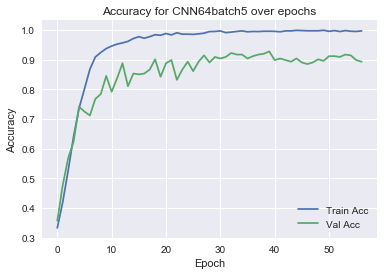

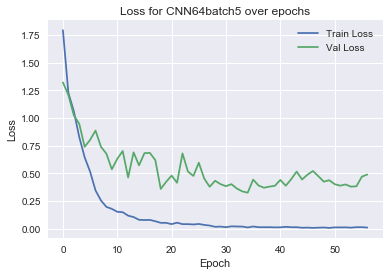

Max val accuracy:  0.9280000001589457
Max train accuracy:  0.9992644354542111


In [11]:
for h in histories:
    checkOutHistory(h)